# **📊 Customer Churn Prediction with PySpark**

## Project Overview

This project uses PySpark and machine learning techniques to predict customer churn for a telecommunications company. The dataset contains information about customers, including demographic and service-related features. The goal is to predict whether a customer will churn (leave the company) or not, based on their attributes.

### Key Features:
- **Imbalanced Dataset**: The target variable (Churn) has an imbalanced distribution, which is addressed using the Synthetic Minority Over-sampling Technique (SMOTE).
- **Logistic Regression**: Logistic Regression is used for classification in this project.
- **PySpark for Distributed Computing**: PySpark is used for processing large datasets efficiently and applying machine learning models at scale.

## Dataset

The dataset used in this project is from the **Telco Customer Churn** dataset, which contains information about customers' services, demographics, and whether they have churned.

### Key Columns:
- **Churn**: Whether the customer has churned (1) or not (0).
- **CustomerID**: Unique identifier for the customer.
- **TotalCharges**: The total amount the customer has been charged.
- **Multiple other columns**: Including gender, senior citizen status, tenure, phone service, internet service, and more.

## Preprocessing Steps

1. **Data Cleaning**:
   - Dropped the `CustomerID` column since it's not needed for modeling.
   - Replaced empty strings in the `TotalCharges` column with `0.0` and converted it to a float.

2. **Label Encoding**:
   - Applied label encoding to all categorical columns (e.g., gender, contract type).

3. **Handling Imbalanced Data**:
   - Applied **SMOTE (Synthetic Minority Over-sampling Technique)** to balance the dataset by generating synthetic samples for the minority class (churn).

4. **Feature Scaling**:
   - Standardized features using `StandardScaler` to improve the performance of the Logistic Regression model.

## Model Building

### Logistic Regression Model

The Logistic Regression model was used for binary classification, predicting whether a customer will churn or not.

- **Input Features**: All columns except the target column (`Churn`).
- **Target Variable**: `Churn` (binary: 0 = No, 1 = Yes).

The model is trained using a **Pipeline** to streamline the process:
1. Assemble features into a single vector.
2. Standardize features.
3. Train the logistic regression model.

### Model Evaluation

The model's performance was evaluated using the following metrics:
- **Accuracy**
- **Confusion Matrix**
- **Precision**
- **Recall**
- **F1-score**

---

# Let's start by importing the required libraries

In [39]:
# Import necessary libraries
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [40]:
# Start Spark session
spark = SparkSession.builder.master("local").appName("ChurnPrediction").getOrCreate()

In [42]:
# Load the dataset
df = pd.read_csv("/Users/ahmedabdulwahid/Desktop/churn model/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [43]:
df.shape

(7043, 21)

In [44]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [46]:
# Data cleaning and preprocessing
df = df.drop(columns=["customerID"])
df["TotalCharges"] = df["TotalCharges"].replace({" ": "0.0"}).astype(float)
df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0})

/var/folders/qg/mkzrt26d3w3g4nybmsfxhqhm0000gn/T/ipykernel_70896/1848633479.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0})


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [48]:
# Label encoding for categorical columns
object_columns = df.select_dtypes(include="object").columns
encoders = {}
for column in object_columns:
    encoder = LabelEncoder()
    df[column] = encoder.fit_transform(df[column])
    encoders[column] = encoder

In [49]:
# Features and target split
X = df.drop(columns=["Churn"])
y = df["Churn"]

X, y

(      gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
 0          0              0        1           0       1             0   
 1          1              0        0           0      34             1   
 2          1              0        0           0       2             1   
 3          1              0        0           0      45             0   
 4          0              0        0           0       2             1   
 ...      ...            ...      ...         ...     ...           ...   
 7038       1              0        1           1      24             1   
 7039       0              0        1           1      72             1   
 7040       0              0        1           1      11             0   
 7041       1              1        1           0       4             1   
 7042       1              0        0           0      66             1   
 
       MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
 0                 1       

In [50]:
# Apply SMOTE to balance the data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [51]:
# Convert to Spark DataFrame
smote_df = pd.DataFrame(X_resampled, columns=X.columns)
smote_df['Churn'] = y_resampled
spark_df = spark.createDataFrame(smote_df)

In [52]:
# Assemble features
feature_cols = [col for col in spark_df.columns if col != 'Churn']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")


In [53]:
# Split the dataset
train_data, test_data = spark_df.randomSplit([0.8, 0.2], seed=42)

In [54]:
# Logistic Regression Model
lr = LogisticRegression(featuresCol="scaled_features", labelCol="Churn")


In [55]:
# Pipeline
pipeline = Pipeline(stages=[assembler, scaler, lr])

In [56]:
# Train the model
model = pipeline.fit(train_data)

In [57]:
# Make predictions
predictions = model.transform(test_data)

In [58]:
# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="Churn")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.89


In [59]:
# Show confusion matrix and classification report
predictions.createOrReplaceTempView("predictions")
spark.sql("""
    SELECT Churn, prediction, COUNT(*) as count
    FROM predictions
    GROUP BY Churn, prediction
""").show()

+-----+----------+-----+
|Churn|prediction|count|
+-----+----------+-----+
|    1|       0.0|  156|
|    0|       1.0|  245|
|    0|       0.0|  783|
|    1|       1.0|  808|
+-----+----------+-----+



In [60]:
y_test = predictions.select("Churn").toPandas()
y_pred = predictions.select("prediction").toPandas()
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.76      0.80      1028
           1       0.77      0.84      0.80       964

    accuracy                           0.80      1992
   macro avg       0.80      0.80      0.80      1992
weighted avg       0.80      0.80      0.80      1992



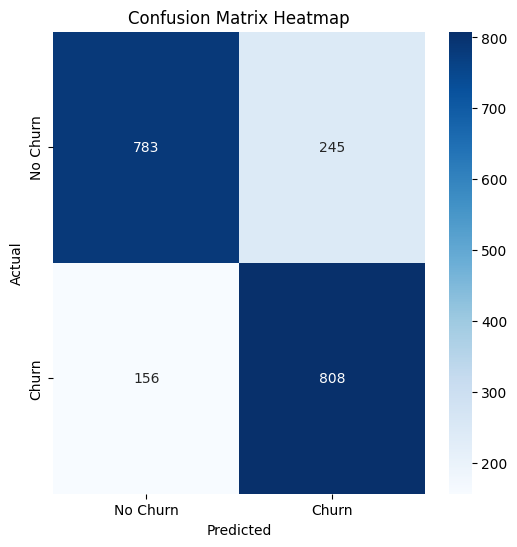

In [61]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

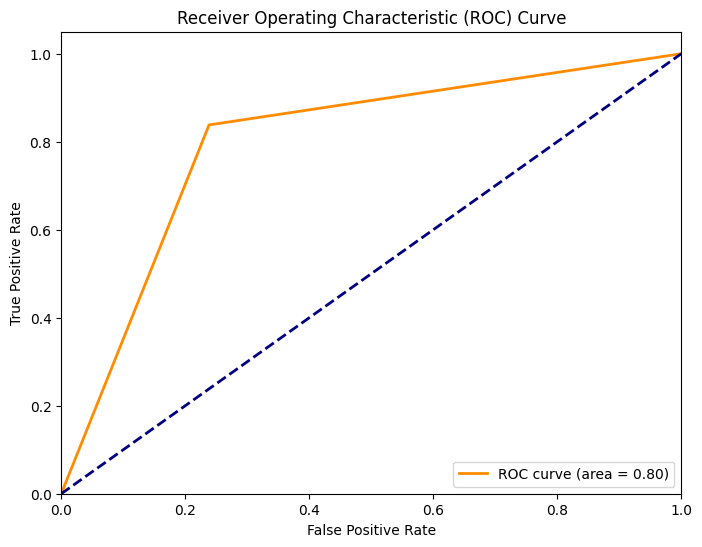

In [62]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

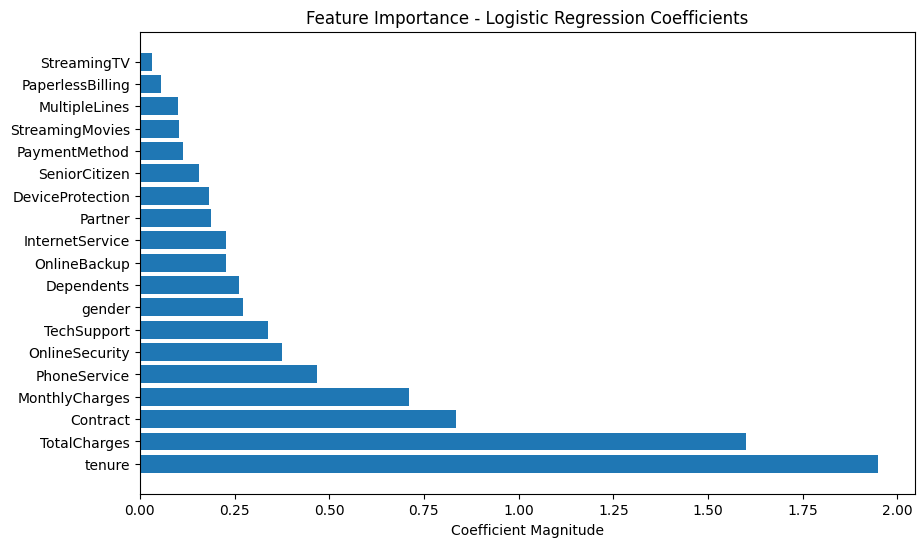

In [63]:
# Get feature names and coefficients from Logistic Regression model
coefficients = model.stages[-1].coefficients.toArray()
feature_names = feature_cols

# Sort coefficients by importance
importance = np.abs(coefficients)
sorted_idx = np.argsort(importance)[::-1]

# Plot feature importance
plt.figure(figsize=(10,6))
plt.barh(np.array(feature_names)[sorted_idx], importance[sorted_idx], align='center')
plt.title('Feature Importance - Logistic Regression Coefficients')
plt.xlabel('Coefficient Magnitude')
plt.show()